In [1]:
import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
from __init__jupyterlab import *
import datetime
from scipy import sparse
import collections
import itertools
import re
import fbpca
import pickle
import scipy.cluster.hierarchy as sch
from sklearn.metrics import euclidean_distances
import h5py

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
figure_format = '/cndd2/fangming/projects/miniatlas/results/figures/{}.pdf'

### Gene annot 

In [3]:
f = PATH_GENEBODY_ANNOTATION
df_genes = pd.read_csv(f, sep='\t')
df_genes['gid'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
print(df_genes.shape)
df_genes.head()


df_genes_v2 = df_genes.groupby('gene_name').first()
print(df_genes_v2.shape)
df_genes_v2.head()

(53379, 8)
(53278, 7)


,gene_id,chr,start,end,strand,gene_type,gid
gene_name,,,,,,,
0610005C13Rik,ENSMUSG00000109644.1,chr7,45567794,45575327,-,antisense_RNA,ENSMUSG00000109644
0610006L08Rik,ENSMUSG00000108652.1,chr7,74818818,74853813,-,lincRNA,ENSMUSG00000108652
0610009B22Rik,ENSMUSG00000007777.9,chr11,51685386,51688874,-,protein_coding,ENSMUSG00000007777
0610009E02Rik,ENSMUSG00000086714.1,chr2,26445696,26459390,+,processed_transcript,ENSMUSG00000086714
0610009L18Rik,ENSMUSG00000043644.4,chr11,120348678,120351190,+,bidirectional_promoter_lncRNA,ENSMUSG00000043644


### MERFISH 

In [4]:
f = '/cndd2/Public_Datasets/CEMBA/BICCN_minibrain_data/Zhuang/cell_metadata.csv'
df = pd.read_csv(f, index_col=0)
print(df.shape)
df.head()

(280327, 14)


,fovID,fov_x,fov_y,volume,center_x,center_y,slice_id,sample_id,AP_distance,soma_depth,label,subclass,class_label,normalized_depth
10000143038275111136124942858811168393,13,4539.310,2986.899,992.830060,4738.397298,3075.327399,mouse2_slice31,dataset2_sample4,400.0,959.227100,Astro_1,Astrocytes,Other,0.712121
100001798412490480358118871918100400402,290,-4016.860,1404.780,610.091871,-3964.711404,1451.889047,mouse2_slice160,dataset2_sample5,1690.0,1246.938980,Endo,Endothelial,Other,0.925716
100006878605830627922364612565348097824,113,750.406,1143.102,148.277718,805.843523,1215.035473,mouse2_slice109,dataset2_sample6,1180.0,7.369782,SMC,SMC,Other,0.005471
100007228202835962319771548915451072492,432,1262.680,-3752.030,249.515471,1348.686198,-3589.955255,mouse1_slice71,dataset1_sample2,700.0,1123.956211,Endo,Endothelial,Other,0.834414
100009332472089331948140672873134747603,354,-3627.450,-1987.730,1779.831996,-3584.650904,-1883.105955,mouse2_slice219,dataset2_sample5,2280.0,324.069916,L23_IT_3,L23_IT,Glutamatergic,0.240586


In [5]:
f = '/cndd2/Public_Datasets/CEMBA/BICCN_minibrain_data/Zhuang/counts.h5ad'
data = h5py.File(f, 'r')
list(data.keys())


['X', 'obs', 'var']

In [6]:
X = data['X'][()]
print(X.shape)
var = data['var'][()]
var = np.array([a[0] for a in data['var'][()]]).astype(str)
print(var.shape)
obs = data['obs'][()]
obs = np.array([a[0] for a in data['obs'][()]]).astype(str)
print(obs.shape)

(280327, 254)
(254,)
(280327,)


In [7]:
var[var=='1-Mar'] = 'March1' # fix small gene name bug
df_genes_v2.reindex(var)['gid'].isnull().sum()

0

In [8]:
data_mfish = pd.DataFrame(X.T, 
                          index=df_genes_v2.reindex(var)['gid'].values, 
                          columns=obs)
print(data_mfish.shape)
data_mfish.head()

(254, 280327)


,10000143038275111136124942858811168393,100001798412490480358118871918100400402,100006878605830627922364612565348097824,100007228202835962319771548915451072492,100009332472089331948140672873134747603,100010715656160197135774164899300304589,100013893144618144270850756017896167367,100017533667894826939857215877082515137,100018466523110786602354542644602732633,100018547319796564052034805202079258035,...,99982182119272612128734924817689360356,99983502058944096412442332908885097416,99983962662904333701864138262453494255,99985816691327783828891364793469425625,99987222586328703024576373872583404495,99987465505639073211021560543065098772,99989592830367590092304100078674096866,99991756591196613545069880666241120777,99997421766159526763299676887100858104,99997470167777465101376150817407669505
ENSMUSG00000028451,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000
ENSMUSG00000036027,0.0,0.0,0.000000,0.0,0.491629,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.835483,0.0,0.480077,0.0,0.00000,0.0,0.0,0.0,0.475026
ENSMUSG00000085129,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.857285,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000
ENSMUSG00000032985,0.0,0.0,0.000000,0.0,0.983257,0.0,0.000000,1.43924,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.55762,0.0,0.0,0.0,0.475026
ENSMUSG00000035783,0.0,0.0,25.567039,0.0,0.491629,0.0,0.877303,0.00000,0.000000,0.0,...,0.0,0.417741,0.0,0.480077,0.0,0.00000,0.0,0.0,0.0,0.000000


In [ ]:
# check counts distribution

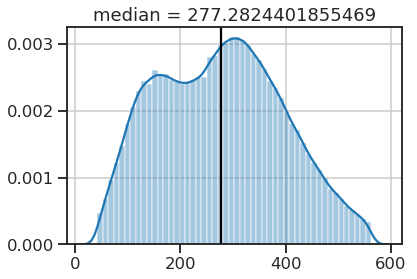

In [16]:
total_counts = data_mfish.sum()

fig, ax = plt.subplots()
sns.distplot(total_counts.values, ax=ax)
ax.axvline(total_counts.median(), color='k',)
ax.set_title('median = {}'.format(total_counts.median()))
plt.show()

In [9]:
# assert np.all(obs==df.index.values)
cells_2 = np.intersect1d(obs, df.index.values)
print(df.index.shape)
print(obs.shape)
print(cells_2.shape)

(280327,)
(280327,)
(280327,)


In [10]:
df['subclass'].unique()

array(['Astrocytes', 'Endothelial', 'SMC', 'L23_IT', 'VLMC', 'L6_CT',
       'L45_IT', 'Pericytes', 'L5_PT', 'L5_IT', 'Microglia', 'Sst',
       'L6_IT', 'Oligodendrocytes', 'Sncg', 'L6_IT_Car3', 'Vip', 'PVM',
       'L56_NP', 'Pvalb', 'OPC', 'other', 'L6b', 'Lamp5', 'Sst_Chodl'], dtype=object)

In [11]:
_x = pd.Series(df['subclass'].unique())
_x[_x.str.contains(r'IT')]

3         L23_IT
6         L45_IT
9          L5_IT
12         L6_IT
15    L6_IT_Car3
dtype: object

In [12]:
_x[_x.str.contains(r'IT$')]

3     L23_IT
6     L45_IT
9      L5_IT
12     L6_IT
dtype: object

In [13]:
cells = df[df['subclass'].fillna('').str.contains(r'IT$')].index
print(cells.shape)
cells = np.intersect1d(cells, cells_2)
print(cells.shape)
df = df.reindex(cells)
data_mfish = data_mfish[cells]

assert np.all(data_mfish.columns.values==df.index.values)
print(df.shape, data_mfish.shape)

(112080,)
(112080,)
(112080, 14) (254, 112080)


In [14]:
df['subclass'].unique()

array(['L23_IT', 'L45_IT', 'L5_IT', 'L6_IT'], dtype=object)

### Save 

In [15]:
print(df.shape)
print(data_mfish.shape)


(112080, 14)
(254, 112080)


In [16]:
outdir = '/cndd2/fangming/projects/miniatlas/data/data_freeze_it_v2'

In [17]:
df.index = 'merfish_' + df.index.values
df.index.name = 'cellID' # this sequence is important

f = os.path.join(outdir, 'merfish_metadata.tsv')
df.to_csv(f, sep='\t', header=True, index=True)

df.head()

,fovID,fov_x,fov_y,volume,center_x,center_y,slice_id,sample_id,AP_distance,soma_depth,label,subclass,class_label,normalized_depth
cellID,,,,,,,,,,,,,,
merfish_100009332472089331948140672873134747603,354,-3627.450,-1987.730,1779.831996,-3584.650904,-1883.105955,mouse2_slice219,dataset2_sample5,2280.0,324.069916,L23_IT_3,L23_IT,Glutamatergic,0.240586
merfish_100017533667894826939857215877082515137,430,5599.161,-678.238,487.182173,5751.425690,-459.415195,mouse2_slice309,dataset2_sample2,3180.0,444.540991,L45_IT_1,L45_IT,Glutamatergic,0.330023
merfish_100018466523110786602354542644602732633,352,-3627.450,-2387.730,1020.683319,-3583.620154,-2208.783457,mouse2_slice219,dataset2_sample5,2280.0,624.303070,L45_IT_SSp_2,L45_IT,Glutamatergic,0.463477
merfish_100019614084014214413331344619872059390,70,-4586.036,-3829.160,292.887615,-4407.951506,-3785.474453,mouse2_slice61,dataset2_sample1,700.0,432.682057,L45_IT_2,L45_IT,Glutamatergic,0.321219
merfish_100023790668886415433490450432243316709,439,-518.876,-1201.836,1533.594802,-357.994530,-1163.662300,mouse2_slice289,dataset2_sample6,2980.0,502.850934,L45_IT_5,L45_IT,Glutamatergic,0.373312


In [18]:
gc_matrix = GC_matrix(
    data_mfish.index.values,
    'merfish_'+data_mfish.columns.values,
    sparse.coo_matrix(data_mfish.values),
)

In [19]:
print(gc_matrix.gene.shape)
print(gc_matrix.cell.shape)
print(gc_matrix.data.shape)

fgene = os.path.join(outdir, 'merfish_hvfeatures.gene')
fcell = os.path.join(outdir, 'merfish_hvfeatures.cell')
fdata = os.path.join(outdir, 'merfish_hvfeatures.npz')
snmcseq_utils.save_gc_matrix(gc_matrix, fgene, fcell, fdata)

(254,)
(112080,)
(254, 112080)


# Read in RS2

In [20]:
f = '/cndd2/fangming/projects/miniatlas/rs2/cell_2111_MOp.hdf5'
data = h5py.File(f, 'r')
list(data.keys())

['genes', 'meta', 'rate_gene_ch']

In [21]:
genes = data['genes'][()]
genes = pd.DataFrame(genes, columns=['chr', 'start', 'end', 'strand', 'gene_id', 'gene_name'])
print(genes.shape)
genes.head()

(12261, 6)


,chr,start,end,strand,gene_id,gene_name
0,chr1,3205900,3671498,-1,ENSMUSG00000051951,Xkr4
1,chr1,3466586,3513553,1,ENSMUSG00000089699,Gm1992
2,chr1,3905738,3986215,-1,ENSMUSG00000102343,Gm37381
3,chr1,3999556,4409241,-1,ENSMUSG00000025900,Rp1
4,chr1,4292980,4409187,-1,ENSMUSG00000109048,Rp1


In [22]:
meta = data['meta'][()]
meta = pd.DataFrame(meta[1:, :], columns=meta[0, :]).astype({
    'mCCC': np.float, 
    'mCH': np.float, 
    'mCG': np.float, 
    '# Non-clonal reads': np.int, 
})
print(meta.shape)
meta.head()

(2111, 10)


,mCCC,mCH,mCG,# Non-clonal reads,Experiment,Source,Slice,Target,Gender,Major Type
0,0.006500,0.032027,0.775850,1090870,Tm3C,MOp,3C,SC,male,L5-ET
1,0.006709,0.034091,0.775146,1458065,Tf3C,MOp,3C,SC,female,L5-ET
2,0.007131,0.035900,0.775895,1614993,Tm4B,MOp,4B,SC,male,L5-ET
3,0.006032,0.028591,0.773345,1598778,Tf4B,MOp,4B,SC,female,L5-ET
4,0.005007,0.022022,0.773471,762007,Pm3C,MOp,3C,STR,male,L4


In [23]:
f = '/cndd2/fangming/projects/miniatlas/rs2/cell_848_L5ET_MOp_6cluster_res4.0_label.npy'
et_clsts = np.load(f)
print(np.unique(et_clsts).shape, et_clsts.shape)

(6,) (848,)


In [24]:
meta_sub = meta[meta['Major Type']=='L5-ET'].sort_index().copy()
meta_sub['Sub Type'] = et_clsts.astype(str)
meta_sub['Major Type'] = ['L5-ET_'+x for x in et_clsts.astype(str)]
print(meta_sub.shape)
meta_sub.head()


(848, 11)


,mCCC,mCH,mCG,# Non-clonal reads,Experiment,Source,Slice,Target,Gender,Major Type,Sub Type
0,0.006500,0.032027,0.775850,1090870,Tm3C,MOp,3C,SC,male,L5-ET_0,0
1,0.006709,0.034091,0.775146,1458065,Tf3C,MOp,3C,SC,female,L5-ET_1,1
2,0.007131,0.035900,0.775895,1614993,Tm4B,MOp,4B,SC,male,L5-ET_2,2
3,0.006032,0.028591,0.773345,1598778,Tf4B,MOp,4B,SC,female,L5-ET_3,3
8,0.006356,0.030536,0.789224,1696759,Tf3C,MOp,3C,SC,female,L5-ET_4,4


In [25]:
meta['Sub Type'] = np.nan
meta.update(meta_sub)
meta.head()

,mCCC,mCH,mCG,# Non-clonal reads,Experiment,Source,Slice,Target,Gender,Major Type,Sub Type
0,0.006500,0.032027,0.775850,1090870.0,Tm3C,MOp,3C,SC,male,L5-ET_0,0
1,0.006709,0.034091,0.775146,1458065.0,Tf3C,MOp,3C,SC,female,L5-ET_1,1
2,0.007131,0.035900,0.775895,1614993.0,Tm4B,MOp,4B,SC,male,L5-ET_2,2
3,0.006032,0.028591,0.773345,1598778.0,Tf4B,MOp,4B,SC,female,L5-ET_3,3
4,0.005007,0.022022,0.773471,762007.0,Pm3C,MOp,3C,STR,male,L4,NaN


In [26]:
nmch = data['rate_gene_ch'][()]
nmch = pd.DataFrame(nmch.T, index=genes['gene_id'], columns=meta.index.values)

print(nmch.shape)
nmch.head()

(12261, 2111)


,0,1,2,3,4,5,6,7,8,9,...,2101,2102,2103,2104,2105,2106,2107,2108,2109,2110
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000051951,0.596484,0.562774,0.973410,0.827507,0.360398,0.394905,0.639581,0.465378,0.802192,0.970619,...,0.698528,0.786778,0.413391,0.853294,0.834699,0.949038,1.016534,0.479156,0.313435,0.844506
ENSMUSG00000089699,0.409485,0.666657,1.105788,0.849973,0.000000,0.593597,0.000000,0.459989,0.957563,1.186581,...,0.271223,0.855781,0.568027,0.806972,0.796711,1.057982,0.584903,0.554740,0.000000,1.005871
ENSMUSG00000102343,0.840626,0.924911,1.172054,0.825084,0.000000,0.763111,0.900269,0.939094,0.987396,0.907598,...,1.161791,0.726675,0.759260,0.830782,0.875541,0.890134,0.788926,1.150925,0.000000,0.766424
ENSMUSG00000025900,1.232800,1.019727,0.865994,0.785467,1.565866,0.638042,0.980718,0.615261,1.052833,0.980608,...,0.926816,0.773509,0.722706,1.106217,1.174742,1.067298,0.997026,0.812896,0.000000,0.852511
ENSMUSG00000109048,1.098876,0.752125,0.463248,0.495499,0.000000,0.393148,1.024092,0.551253,0.859545,0.924681,...,1.013985,0.703422,0.715443,0.876114,0.909458,1.088331,1.006497,0.696407,0.000000,0.748122


In [27]:
meta['Major Type'].unique()

array(['L5-ET_0', 'L5-ET_1', 'L5-ET_2', 'L5-ET_3', 'L4', 'L2/3', 'L6-IT',
       'L5-ET_4', 'L5-IT', 'L5-ET_5', 'Inh', 'L6-CT', 'L6b', 'CLA', 'NP'], dtype=object)

In [28]:
cells = meta[meta['Major Type'].str.contains(r'L2/3|L4|IT')].index
meta = meta.reindex(cells)
nmch = nmch[cells.values]

In [29]:
meta['Major Type'].unique()

array(['L4', 'L2/3', 'L6-IT', 'L5-IT'], dtype=object)

### Save 

In [30]:
print(meta.shape)
print(nmch.shape)

(1110, 11)
(12261, 1110)


In [31]:
meta.index = ['epi_retro_'+str(cellid) for cellid in meta.index.values]
meta.index.name = 'cellID'

f = os.path.join(outdir, 'epi_retro_metadata.tsv')
meta.to_csv(f, sep='\t', header=True, index=True)

meta.head()

,mCCC,mCH,mCG,# Non-clonal reads,Experiment,Source,Slice,Target,Gender,Major Type,Sub Type
cellID,,,,,,,,,,,
epi_retro_4,0.005007,0.022022,0.773471,762007.0,Pm3C,MOp,3C,STR,male,L4,NaN
epi_retro_5,0.005096,0.021157,0.769823,1872338.0,Pf3C,MOp,3C,STR,female,L4,NaN
epi_retro_6,0.005480,0.023323,0.764852,1888159.0,Pf4B,MOp,4B,STR,female,L2/3,NaN
epi_retro_7,0.005206,0.023694,0.780726,1990555.0,Tm3C,MOp,3C,SC,male,L6-IT,NaN
epi_retro_10,0.005330,0.025011,0.762114,1352644.0,Pm3C,MOp,3C,STR,male,L5-IT,NaN


In [32]:
# nmch.shape
f = os.path.join(outdir, 'epi_retro_hvfeatures.tsv')
nmch.columns = ['epi_retro_'+str(cellid) for cellid in nmch.columns.values]
nmch.to_csv(f, sep='\t', header=True, index=True)
nmch.head()

,epi_retro_4,epi_retro_5,epi_retro_6,epi_retro_7,epi_retro_10,epi_retro_11,epi_retro_12,epi_retro_16,epi_retro_17,epi_retro_18,...,epi_retro_2048,epi_retro_2053,epi_retro_2054,epi_retro_2062,epi_retro_2066,epi_retro_2069,epi_retro_2085,epi_retro_2091,epi_retro_2095,epi_retro_2103
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000051951,0.360398,0.394905,0.639581,0.465378,0.499260,0.767542,0.395766,0.409176,0.407850,0.506268,...,0.547256,0.637801,0.646330,0.415846,0.508821,0.673310,0.479456,0.686571,0.522642,0.413391
ENSMUSG00000089699,0.000000,0.593597,0.000000,0.459989,0.690104,0.842951,0.079994,0.386751,0.508490,0.485839,...,0.000000,0.923293,0.244310,0.399472,0.000000,0.201748,0.481562,0.318339,0.502000,0.568027
ENSMUSG00000102343,0.000000,0.763111,0.900269,0.939094,0.633643,0.777355,1.226021,0.632830,0.834135,1.027706,...,0.941565,0.952146,0.579236,0.864296,0.831057,0.939606,0.511011,0.598749,0.832558,0.759260
ENSMUSG00000025900,1.565866,0.638042,0.980718,0.615261,0.826621,0.814328,0.682057,0.685734,0.740894,0.729502,...,0.657522,0.537038,0.827877,0.611318,0.596293,0.748243,0.724873,0.586906,0.739377,0.722706
ENSMUSG00000109048,0.000000,0.393148,1.024092,0.551253,0.532218,1.249667,0.748174,0.533323,0.713785,0.470878,...,0.554452,0.447695,0.871294,0.533078,0.547896,0.872950,0.806973,0.648370,1.078524,0.715443
